In [1]:
import os
import numpy as np
import readdy

__Setup ReaDDy system__

The intrinsic forward rate $\lambda_\mathrm{f}$ is obtained from the macroscopic forward rate 
$k_\mathrm{f} = 5.88 \,\mathrm{\mu M}^{-1} \mathrm{s}^{-1} = 0.98 \times 10^{-2} \mathrm{\mu m}^{3} \mathrm{s}^{-1}$ by 
application of

$$
k_\mathrm{f} = 4\pi (D_E + D_S) R \left[1 - \frac{\tanh(\kappa R)}{\kappa R}\right]
$$

where

$$
\kappa = \sqrt{\frac{\lambda_\mathrm{f}}{D_E + D_S}}
$$

as described in [1]. Note that this will only work in the well mixed regime. The equation cannot be solved explicitly for $\kappa$. Hence, the intrinsic rate was numerically approximated by solving a minimization problem.


[1] R. Erban and J. Chapman, “Stochastic modelling of reaction-diffusion processes: algorithms for bimolecular reactions.,” Phys. Biol., vol. 6, no. 4, p. 46001, Jan. 2009.

In [2]:
system = readdy.ReactionDiffusionSystem(
    box_size=[0.3, 0.3, 0.3],
    unit_system={"length_unit": "micrometer", "time_unit": "second"}
)

system.add_species("E", diffusion_constant=10.)
system.add_species("S", diffusion_constant=10.)
system.add_species("ES", diffusion_constant=10.)
system.add_species("P", diffusion_constant=10.)

system.reactions.add("fwd: E +(0.03) S -> ES", rate=86.78638438)
system.reactions.add("back: ES -> E +(0.03) S", rate=1.)
system.reactions.add("prod: ES -> E +(0.03) P", rate=1.)

__Simulate the system__

In [10]:
simulation = system.simulation(kernel="CPU")
simulation.output_file = "out.h5"
simulation.reaction_handler = "UncontrolledApproximation"

n_particles_e = 909
n_particles_s = 9091
edge_length = system.box_size[0]
initial_positions_e = np.random.random(size=(n_particles_e, 3)) * edge_length - .5*edge_length
initial_positions_s = np.random.random(size=(n_particles_s, 3)) * edge_length - .5*edge_length
simulation.add_particles("E", initial_positions_e)
simulation.add_particles("S", initial_positions_s)

simulation.observe.number_of_particles(stride=1, types=["E", "S", "ES", "P"])

In [11]:
if os.path.exists(simulation.output_file):
    os.remove(simulation.output_file)

dt = 1e-3
n_steps = int(10. / dt)

simulation.run(n_steps=n_steps, timestep=dt)

Simulation progress: 100% (101/101) [##############################] eta 00:00 -

__Obtain simulation output__

In [12]:
traj = readdy.Trajectory(simulation.output_file)
time, counts = traj.read_observable_number_of_particles()
counts = counts / system.box_volume.magnitude
time = time * dt

__Analytical solution (integrated ODE)__

In [13]:
from scipy.integrate import odeint

def f(x, t0, kf, kr, kcat):
    """
    x: state vector with concentrations of E, S, ES, P
    """
    return np.array([
        -kf * x[0] * x[1] + (kr+kcat)*x[2],
        -kf * x[0] * x[1] + kr * x[2],
        kf * x[0] * x[1]- (kr+kcat)*x[2],
        kcat*x[2]
    ])

init_state = np.array([n_particles_e, n_particles_s, 0., 0.]) / system.box_volume.magnitude
ode_time = np.linspace(0.,10,100000)
ode_result = odeint(f, y0=init_state, t=ode_time, args=(0.98e-2, 1., 1.))

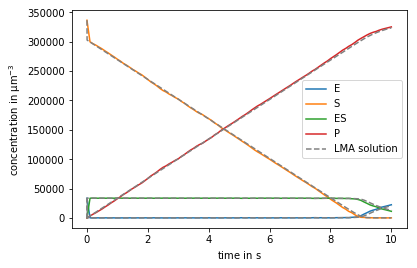

In [14]:
import matplotlib.pyplot as plt

stride = 100
plt.plot(time[::stride], counts[:,0][::stride], "-", label='E')
plt.plot(time[::stride], counts[:,1][::stride], "-", label='S')
plt.plot(time[::stride], counts[:,2][::stride], "-", label='ES')
plt.plot(time[::stride], counts[:,3][::stride], "-", label='P')
plt.plot(ode_time, ode_result[:,0], "--", color="grey", label="LMA solution")
plt.plot(ode_time, ode_result[:,1], "--", color="grey")
plt.plot(ode_time, ode_result[:,2], "--", color="grey")
plt.plot(ode_time, ode_result[:,3], "--", color="grey")
plt.legend()
plt.xlabel(r"time in $\mathrm{s}$")
plt.ylabel(r"concentration in $\mathrm{\mu m}^{-3}$")
plt.show()

__Performance data__

In [15]:
perf = simulation._simulation.performance_root()

In [16]:
print(perf)

simulation: time 379.476 s, count 1
	initNeighborList: time 0.028022 s, count 1
		set_up: time 0.028017 s, count 1
			setUp CLL: time 0.002017 s, count 1
				setUpCellNeighbors: time 0.001578 s, count 1
				setUpBins: time 0.000423 s, count 1
					allocate: time 8e-06 s, count 1
					fillBins parallel: time 0.000408 s, count 1
			fill verlet list: time 0.025988 s, count 1
				fill verlet list: time 0.025985 s, count 1
	forces: time 0.023997 s, count 10001
	integrator: time 7.85859 s, count 10000
	neighborList: time 353.778 s, count 20000
		update: time 353.728 s, count 20000
			update CLL: time 5.00688 s, count 20000
				setUpBins: time 4.98204 s, count 20000
					allocate: time 0.084735 s, count 20000
					fillBins parallel: time 4.84386 s, count 20000
			fill verlet list: time 348.628 s, count 20000
				fill verlet list: time 348.557 s, count 20000
	reactionScheduler: time 15.8888 s, count 10000
	evaluateTopologyReactions: time 0.000806 s, count 10000
	clearNeighborList: time 1e-06 s